In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when, avg, collect_list

In [2]:
spark = SparkSession.builder.appName("Project").getOrCreate()

CLASSIFICATION

In [6]:
df = spark.read.csv(r"file:///Users\\49921659768\\Desktop\\CENG-567-Big Data Mining Application\\cardekho_data_classification.csv", header=True, inferSchema=True)

#indexing
idx = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Car_Name", "Fuel_Type", "Seller_Type", "Transmission"]]
pipeline = Pipeline(stages=idx)
df_idx = pipeline.fit(df).transform(df)

#Calculating average selling price for threshold.
avg_selling_price = round((df.agg(avg(col("Selling_Price"))).collect()[0][0]),1)


assembler = VectorAssembler(inputCols=["Year", "Present_Price", "Kms_Driven", "Owner", 
                   "Car_Name_index", "Fuel_Type_index", "Seller_Type_index", "Transmission_index"], outputCol="features")
df_assembled = assembler.transform(df_idx)

#Label column creation
price_threshold = avg_selling_price # In this case, we're assuming that any car with a selling price greater than or equal to 4.7(which is average of selling price column) is considered a "good deal" and below 4.7 is "not a good deal".
kms_threshold = 30000 # I chose kms_driven max value as 30000 for test.
year_threshold = 2010

df_with_label = df_assembled.withColumn("label",when((col("Selling_Price") >= price_threshold) & \
                                              (col("Year") >= year_threshold) & \
                                              (col("Kms_Driven") <= kms_threshold), 2) \
                                         .when((col("Selling_Price") >= price_threshold) & \
                                              (col("Year") >= year_threshold), 1) \
                                         .when((col("Selling_Price") >= price_threshold), 0).otherwise(3))

# Label 0: Cars with selling prices significantly higher than the average, but do not meet additional conditions can still be bought.
# Label 1: Cars with selling prices higher than average and manufactured after or in 2010, considered good deals.
# Label 2: Cars with selling prices higher than average, manufactured after or in 2010, and with kilometers driven lower than 30000, considered great deals.
# Label 3: Cars that do not meet any of the above conditions, considered not recommended to buy.

#Split the data
(trainingData, testData) = df_with_label.randomSplit([0.8, 0.2], seed=42)

#Training the model
dt_classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=100)
dt_model = dt_classifier.fit(trainingData)

#Evaluation of the model
dt_predictions = dt_model.transform(testData)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dt_predictions)
print("Decision Tree Accuracy:", round(accuracy,2))

Decision Tree Accuracy: 0.83


CLUSTERING

root
 |-- Sl_No: integer (nullable = true)
 |-- Customer Key: integer (nullable = true)
 |-- Avg_Credit_Limit: integer (nullable = true)
 |-- Total_Credit_Cards: integer (nullable = true)
 |-- Total_visits_bank: integer (nullable = true)
 |-- Total_visits_online: integer (nullable = true)
 |-- Total_calls_made: integer (nullable = true)

660


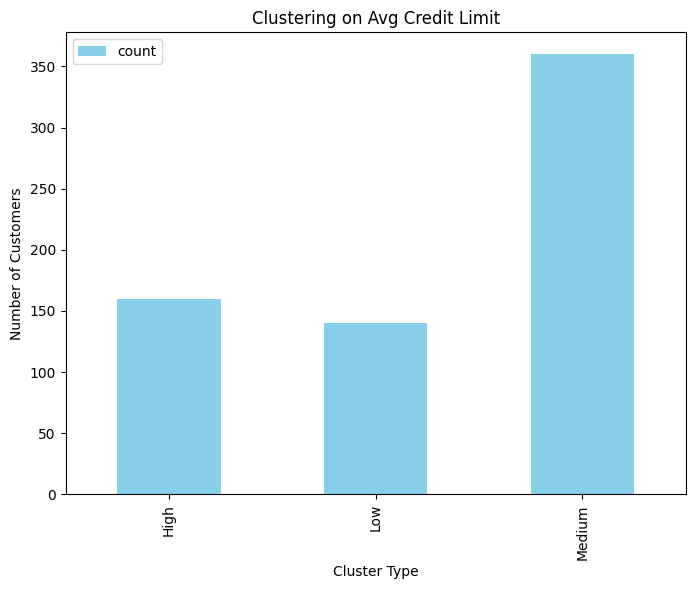

In [5]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
df2 = spark.read.csv(r"file:///Users\\49921659768\\Desktop\\CENG-567-Big Data Mining Application\\credit_card_customer_data_clustering.csv", header=True, inferSchema=True)
df2.printSchema()
print(df2.count())
# Assemble features
feature_columns = ["Avg_Credit_Limit", "Total_Credit_Cards", "Total_visits_bank", "Total_visits_online", "Total_calls_made"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df2)

# Scale features
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Define clusters based on average credit limit ranges
data = data.withColumn("Cluster", 
                       when((data["Avg_Credit_Limit"] < 10000), "Low")\
                      .when((data["Avg_Credit_Limit"] >= 10000) & (data["Avg_Credit_Limit"] < 50000), "Medium")\
                      .otherwise("High"))

# Group by clusters and count the number of customers in each cluster
cluster_count = data.groupBy("Cluster").count()

#Visualize
pd_cluster_count = cluster_count.toPandas()

fig, ax = plt.subplots(1, 1, figsize =(8, 6))
pd_cluster_count.plot(kind='bar', x='Cluster', y='count', ax=ax, color='skyblue')
ax.set_xlabel('Cluster Type')
ax.set_ylabel('Number of Customers')
ax.set_title('Clustering on Avg Credit Limit')

plt.show()

ASSOCIATION RULE MINING

In [7]:
from pyspark.ml.fpm import FPGrowth
df3 = spark.read.csv(r"file:///Users\\49921659768\\Desktop\\CENG-567-Big Data Mining Application\\bakery_arm.csv", header=True, inferSchema=True)

basketdata = df3.dropDuplicates(['TransactionNo', 'Items']).sort('TransactionNo')
basketdata = basketdata.groupBy("TransactionNo").agg(collect_list("Items")).sort('TransactionNo')

#Frequent Pattern Growth – FP Growth is a method of mining frequent itemsets
fpGrowth = FPGrowth(itemsCol="collect_list(Items)", minSupport=0.006, minConfidence=0.006) 
model = fpGrowth.fit(basketdata)

# Display frequent itemsets.
model.freqItemsets.show()
items = model.freqItemsets
# Display generated association rules.
model.associationRules.show()
rules = model.associationRules
# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(basketdata).show()
transformed = model.transform(basketdata)

+--------------------+----+
|               items|freq|
+--------------------+----+
|               [Jam]| 142|
|  [Keeping It Local]|  63|
|      [Scandinavian]| 275|
|[Scandinavian, Br...|  62|
|           [Cookies]| 515|
|      [Cookies, Tea]|  93|
|[Cookies, Hot cho...|  57|
|    [Cookies, Bread]| 137|
|     [Cookies, Cake]|  69|
|   [Cookies, Coffee]| 267|
|    [Jammie Dodgers]| 125|
|[Jammie Dodgers, ...|  63|
|             [Juice]| 365|
|    [Juice, Cookies]|  58|
|        [Juice, Tea]|  68|
|      [Juice, Bread]|  70|
|       [Juice, Cake]|  67|
|     [Juice, Coffee]| 195|
|             [Salad]|  99|
|     [Salad, Coffee]|  62|
+--------------------+----+
only showing top 20 rows

+-------------------+--------------+--------------------+-------------------+--------------------+
|         antecedent|    consequent|          confidence|               lift|             support|
+-------------------+--------------+--------------------+-------------------+--------------------+
|  [S

In [8]:
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
result_pdf = items.select("*").toPandas()
result_pdf.head()

,items,freq
0,[Jam],142
1,[Keeping It Local],63
2,[Scandinavian],275
3,"[Scandinavian, Bread]",62
4,[Cookies],515


In [10]:
result_pdf.to_csv('result_pdfItemsFreq.csv')

In [11]:
rules_pdf = rules.select("*").toPandas()
rules_pdf.head()

,antecedent,consequent,confidence,lift,support
0,"[Sandwich, Bread]",[Coffee],0.422360,0.882871,0.007184
1,[Tiffin],[Coffee],0.547945,1.145385,0.008452
2,[Medialuna],[Tea],0.131624,0.922830,0.008135
3,[Medialuna],[Pastry],0.148718,1.727135,0.009192
4,[Medialuna],[Bread],0.273504,0.835879,0.016904


In [12]:
rules_pdf.to_csv('rules_pdfAnteConseConfLift.csv')

In [13]:
transformed_pdf = transformed.select("*").toPandas()
transformed_pdf.head()

,TransactionNo,collect_list(Items),prediction
0,1,[Bread],"[Scandinavian, Cookies, Juice, Tea, Sandwich, ..."
1,2,[Scandinavian],[Bread]
2,3,"[Hot chocolate, Cookies, Jam]","[Tea, Bread, Cake, Coffee, Juice]"
3,4,[Muffin],"[Tea, Bread, Coffee]"
4,5,"[Coffee, Pastry, Bread]","[Scandinavian, Cookies, Juice, Tea, Sandwich, ..."


In [14]:
transformed_pdf.to_csv('transformed_pdfSalesTransactionIDCollectListPred.csv')